In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

### 그림그리는 함수

In [2]:
def show_v_table_small(v_table, env):
    for i in range(env.reward.shape[0]):        
        print("+----------"*env.reward.shape[1])
        print("|", end="")
        for j in range(env.reward.shape[1]):
            print("{0:8.2f}  |".format(v_table[i,j]),end="")
        print()
    print("+----------"*env.reward.shape[1])

# V table 그리기    
def show_v_table(v_table, env):    
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("                 |",end="")
                if k==1:
                        print("   {0:8.2f}      |".format(v_table[i,j]),end="")
                if k==2:
                    print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")
    
# Q table 그리기
def show_q_table(q_table,env):
    for i in range(env.reward.shape[0]):
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("{0:10.2f}       |".format(q_table[i,j,0]),end="")
                if k==1:
                    print("{0:6.2f}    {1:6.2f} |".format(q_table[i,j,3],q_table[i,j,1]),end="")
                if k==2:
                    print("{0:10.2f}       |".format(q_table[i,j,2]),end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")
    

# 정책 policy 화살표로 그리기
def show_q_table_arrow(q_table,env):
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    if np.max(q[i,j,:]) == q[i,j,0]:
                        print("        ↑       |",end="")
                    else:
                        print("                 |",end="")
                if k==1:                    
                    if np.max(q[i,j,:]) == q[i,j,1] and np.max(q[i,j,:]) == q[i,j,3]:
                        print("      ←  →     |",end="")
                    elif np.max(q[i,j,:]) == q[i,j,1]:
                        print("          →     |",end="")
                    elif np.max(q[i,j,:]) == q[i,j,3]:
                        print("      ←         |",end="")
                    else:
                        print("                 |",end="")
                if k==2:
                    if np.max(q[i,j,:]) == q[i,j,2]:
                        print("        ↓       |",end="")
                    else:
                        print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")    
    
# 정책 policy 화살표로 그리기
def show_policy_small(policy,env):
    for i in range(env.reward.shape[0]):        
        print("+----------"*env.reward.shape[1],end="")
        print("+")
        print("|", end="")
        for j in range(env.reward.shape[1]):
            if env.reward_list1[i][j] == "road":
                if policy[i,j] == 0:
                    print("   ↑     |",end="")
                elif policy[i,j] == 1:
                    print("   →     |",end="")
                elif policy[i,j] == 2:
                    print("   ↓     |",end="")
                elif policy[i,j] == 3:
                    print("   ←     |",end="")
            else:
                print("          |",end="")
        print()
    print("+----------"*env.reward.shape[1],end="")
    print("+")
    
# 정책 policy 화살표로 그리기
def show_policy(policy,env):
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("                 |",end="")
                if k==1:
                    if policy[i,j] == 0:
                        print("      ↑         |",end="")
                    elif policy[i,j] == 1:
                        print("      →         |",end="")
                    elif policy[i,j] == 2:
                        print("      ↓         |",end="")
                    elif policy[i,j] == 3:
                        print("      ←         |",end="")
                if k==2:
                    print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")

### Agent 구현

In [3]:
class Agent():
    
    # 1. 행동에 따른 에이전트의 좌표 이동(위, 오른쪽, 아래, 왼쪽) 
    action = np.array([[-1,0],[0,1],[1,0],[0,-1]])
    
    # 2. 각 행동별 선택확률
    select_action_pr = np.array([0.25,0.25,0.25,0.25])
    
    # 3. 에이전트의 초기 위치 저장
    def __init__(self):
        self.pos = (0,0)
    
    # 4. 에이전트의 위치 저장
    def set_pos(self,position):
        self.pos = position
        return self.pos
    
    # 5. 에이전트의 위치 불러오기
    def get_pos(self):
        return self.pos

### Environment 구현

In [4]:
class Environment():
    
    # 1. 미로밖(절벽), 길, 목적지, 벽과 보상 설정
    cliff = -3
    road = -1
    goal = 1
    wall = -3
    
    # 2. 목적지 좌표 설정
    goal_position = [5,5]
    
    # 3. 보상 리스트 숫자 [list를 numpy에 대한 함수로 변환해서 써야 데이터양이 많아질 때 유용함]
    reward_list = [[road,wall,road,road,road,road],
                   [road,wall,road,road,wall,road],
                   [road,wall,road,road,road,road],
                   [road,wall,road,wall,road,road],
                   [road,road,road,wall,wall,road],
                   [road,wall,road,road,wall,goal]]
    
    # 4. 보상 리스트 문자
    reward_list1 = [["road","wall","road","road","road","road"],
                    ["road","wall","road","road","wall","road"],
                    ["road","wall","road","road","road","road"],
                    ["road","wall","road","wall","road","road"],
                    ["road","road","road","wall","wall","road"],
                    ["road","wall","road","road","wall","goal"]]
    
    # 5. 보상 리스트를 array로 설정, np=numpy임, 
    def __init__(self):
        self.reward = np.asarray(self.reward_list)    

    # 6. 선택된 에이전트의 행동 결과 반환 (미로밖일 경우 이전 좌표로 다시 복귀)
    def move(self, agent, action):
        
        done = False
        
        # 6.1 행동에 따른 좌표 구하기
        new_pos = agent.pos + agent.action[action]
        
        # 6.2 현재좌표가 목적지 인지확인
        if self.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
            reward = self.goal
            observation = agent.set_pos(agent.pos)
            done = True
        # 6.3 이동 후 좌표가 미로 밖인 확인    
        elif new_pos[0] < 0 or new_pos[0] >= self.reward.shape[0] or new_pos[1] < 0 or new_pos[1] >= self.reward.shape[1]:
            reward = self.cliff and self.wall
            observation = agent.set_pos(agent.pos)
            done = True
        # 6.4 이동 후 좌표가 길이라면
        else:
            observation = agent.set_pos(new_pos)
            reward = self.reward[observation[0],observation[1]]
            
        return observation, reward, done

### 재귀적으로 상태 가치함수를 계산하는 함수

In [5]:
# 상태 가치 계산
def state_value_function(env,agent,G,max_step,now_step):
    
    # 1. 감가율 설정
    gamma = 0.9
    
# 2. 현재 위치가 도착지점인지 확인
    if env.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
        return env.goal
    
# 3. 마지막 상태는 보상만 계산
    if (max_step == now_step):
        pos1 = agent.get_pos()
        
        # 3.1 가능한 모든 행동의 보상을 계산
        for i in range(len(agent.action)):
            agent.set_pos(pos1)
            observation, reward, done = env.move(agent,i)
            G += agent.select_action_pr[i] * reward
            
        return G
    
    # 4. 현재 상태의 보상을 계산한 후 다음 step으로 이동
    else:
        
        # 4.1현재 위치 저장
        pos1 = agent.get_pos()
        
        # 4.2 현재 위치에서 가능한 모든 행동을 조사한 후 이동
        for i in range(len(agent.action)):
            observation, reward, done = env.move(agent,i)      
            # 4.2.1 현재 상태에서 보상을 계산
            G += agent.select_action_pr[i] * reward

            # 4.2.2 이동 후 위치 확인 : 미로밖, 벽, 구멍인 경우 이동전 좌표로 다시 이동
            if done == True:
                if observation[0] < 0 or observation[0] >= env.reward.shape[0] or observation[1] < 0 or observation[1] >= env.reward.shape[1]:
                    agent.set_pos(pos1)

            # 4.2.3 다음 step을 계산
            next_v = state_value_function(env, agent, 0, max_step, now_step+1)
            G += agent.select_action_pr[i] * gamma * next_v

            # 4.2.4 현재 위치를 복구
            agent.set_pos(pos1)

        return G


### 미로의 각 상태의 상태가치함수를 구하는 함수

No handles with labels found to put in legend.


max_step_number = 0 total_time = 0.0(s)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.50      |      -2.00      |      -2.00      |      -1.50      |      -2.00      |      -2.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.00      |      -2.00      |      -1.50      |      -1.50      |      -1.00      |      -2.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-------

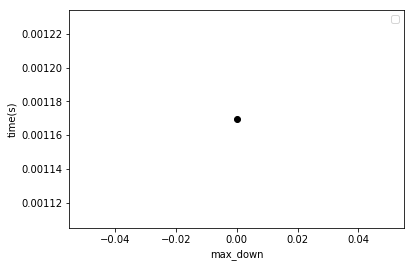

In [6]:
# 1. 환경 초기화
env = Environment()

# 2. 에이전트 초기화
agent = Agent()

# 3. 최대 max_step_number 제한
max_step_number = 1

# 4. 계산 시간 저장을 위한 list
time_len = []

# 5. 재귀함수 state_value_function을를 이용해 각 상태 가치를 계산
for max_step in range(max_step_number):
    
    # 5.1 미로 각 상태의 가치를 테이블 형식으로 저장
    v_table = np.zeros((env.reward.shape[0],env.reward.shape[1]))    
    start_time = time.time()
    
    # 5.2 미로의 각 상태에 대해 state_value_function() 을 이용해 가치를 계산한 후 테이블 형식으로 저장
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            agent.set_pos([i,j])
            v_table[i,j] = state_value_function(env,agent, 0, max_step, 0)
            
    # 5.3 max_down에 따른 계산시간 저장
    time_len.append(time.time()-start_time)
    print("max_step_number = {} total_time = {}(s)".format(max_step, np.round(time.time()-start_time,2)))
    
    show_v_table(np.round(v_table,2),env)

# 6. step 별 계산 시간 그래프 그리기    
plt.plot(time_len, 'o-k')
plt.xlabel('max_down')
plt.ylabel('time(s)')
plt.legend()
plt.show()

### 재귀적으로 행동가치함수를 계산하는 함수

In [7]:
# 행동 가치 함수 (상태가치함수에다가 act가 추가됨)
def action_value_function(env, agent, act, G, max_step, now_step):   
    
    # 1. 감가율 설정
    gamma = 0.9
    
    # 2. 현재 위치가 목적지인지 확인
    if env.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
        return env.goal

    # 3. 마지막 상태는 보상만 계산 (G값에 넣어서 반환해준다는 것이 가장 큰 차이점이다)
    if (max_step == now_step):
        observation, reward, done = env.move(agent, act)
        G += agent.select_action_pr[act]*reward
        return G
    

    # 4. 현재 상태의 보상을 계산한 후 다음 행동과 함께 다음 step으로 이동
    else:
        # 4.1현재 위치 저장
        pos1 = agent.get_pos()
        observation, reward, done = env.move(agent, act)
        G += agent.select_action_pr[act] * reward
        
        # 4.2 이동 후 위치 확인 : 미로밖, 벽, 구멍인 경우 이동전 좌표로 다시 이동
        if done == True:            
            if observation[0] < 0 or observation[0] >= env.reward.shape[0] or observation[1] < 0 or observation[1] >= env.reward.shape[1] or env.reward_list1[agent.pos[0]][agent.pos[1]] == "wall":
                agent.set_pos(pos1)
            
        # 4.3 현재 위치를 다시 저장
        pos1 = agent.get_pos()
        
        # 4.4 현재 위치에서 가능한 모든 행동을 선택한 후 이동
        for i in range(len(agent.action)):
            agent.set_pos(pos1)
            next_v = action_value_function(env, agent, i, 0, max_step, now_step+1)
            G += agent.select_action_pr[i] * gamma * next_v
        return G

### 미로의 각 상태의 행동가치함수를 구하는 함수

In [8]:
# 재귀적으로 행동의 가치를 계산

# 1. 환경 초기화
env = Environment()

# 2. 에이전트 초기화
agent = Agent()
np.random.seed(0)

# 3. 현재부터 max_step 까지 계산
max_step_number = 6

# 4. 모든 상태에 대해
for max_step in range(5,max_step_number):
    # 4.1 미로 상의 모든 상태에서 가능한 행동의 가치를 저장할 테이블을 정의
    print("max_step = {}".format(max_step))
    q_table = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            # 4.2 모든 행동에 대해
            if env.reward_list1[i][j] != "wall":
                for action in range(len(agent.action)):
                    # 4.2.1 에이전트의 위치를 초기화
                    agent.set_pos([i,j])
                    # 4.2.2 현재 위치에서 행동 가치를 계산
                    q_table[i ,j,action] = action_value_function(env, agent, action, 0, max_step, 0)

    q = np.round(q_table,2)
    print("Q - table")
    show_q_table(q, env)
    print("High actions Arrow")
    show_q_table_arrow(q,env)
    print()

max_step = 5
Q - table
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.82       |      0.00       |     -2.45       |     -2.27       |     -2.39       |     -2.48       |
| -2.82     -2.61 |  0.00      0.00 | -2.61     -1.77 | -1.95     -1.89 | -1.77     -1.98 | -1.89     -2.48 |
|     -2.13       |      0.00       |     -1.80       |     -1.69       |     -2.13       |     -1.87       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.32       |      0.00       |     -1.95       |     -1.77       |      0.00       |     -1.98       |
| -2.63     -2.53 |  0.00      0.00 | -2.53     -1.69 | -1.80     -2.13 |  0.00      0.00 | -2.13     -2.37 |
|     -2.05       |      0.00       |     -1.78       |     -1.71       |      0.00       |     -1.69       |
+-----------------+-----------------+-----------------+-----------------+-----------------+------

### 반복 정책 평가

In [17]:
# 반복 정책 평가
np.random.seed(0)
env = Environment()
agent = Agent()
gamma = 0.9

# 1. 모든 𝑠∈𝑆^에 대해서 배열 𝑉(𝑠)=0으로 초기화
v_table = np.zeros((env.reward.shape[0],env.reward.shape[1]))

print("start Iterative Policy Evaluation")

k = 1
print()
print("V0(S)   k = 0")

# 초기화된 V 테이블 출력
show_v_table(np.round(v_table,2),env)

# 시작 시간 변수에 저장
start_time = time.time()

# 반복
while(True):    
    # 2. Δ←0
    delta = 0
    # 3. v←(𝑠)
    # 계산전 가치를 저장
    temp_v = copy.deepcopy(v_table)
    # 4. 모든 𝑠∈𝑆에 대해 : 
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            G = 0
            # 5. 가능한 모든 행동으로 다음상태만 이용해 𝑉(𝑠) 계산
            for action in range(len(agent.action)):
                agent.set_pos([i,j])
                observation, reward, done = env.move(agent, action)
                
#                 print("s({0}): {1:5s} : {2:0.2f} = {3:0.2f} *({4:0.2f} +  {5:0.2f} *  {6:0.2f})".format(i*env.reward.shape[0]+j,dic[action],agent.select_action_pr[action] * (reward + gamma*V[observation[0],observation[1]]), agent.select_action_pr[action],reward,gamma,V[observation[0],observation[1]]))

                G += agent.select_action_pr[action] * (reward + gamma*v_table[observation[0],observation[1]])                    

#             print("V{2}({0}) :sum = {1:.2f}".format(i*env.reward.shape[0]+j,total,k))
#             print()
            v_table[i,j] = G
    # 6. ∆←max⁡(∆,|v−𝑉(𝑠)|)
    # 계산전과 계산후의 가치 차이 계산
    delta = np.max([delta, np.max(np.abs(temp_v-v_table))])
    
    end_time = time.time()        
    print("V{0}(S) : k = {1:3d}    delta = {2:0.6f} total_time = {3}".format(k,k, delta,np.round(end_time-start_time),2))
    show_v_table(np.round(v_table,2),env)                
    k +=1

    # 7. ∆ <𝜃가 작은 양수 일 때까지 반복

    if delta < 0.000001:
        break
        
end_time = time.time()        
print("total_time = {}".format(np.round(end_time-start_time),2))



start Iterative Policy Evaluation

V0(S)   k = 0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.00      |       0.00      |       0.00      |       0.00      |       0.00      |       0.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.00      |       0.00      |       0.00      |       0.00      |       0.00      |       0.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+----------------

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -10.40      |     -10.29      |      -9.86      |      -9.10      |      -9.56      |     -10.01      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -10.40      |     -10.68      |      -9.93      |      -9.47      |      -9.20      |     -10.26      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|         

|     -15.77      |     -15.89      |     -15.18      |     -14.34      |     -11.45      |      -6.68      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -16.96      |     -15.81      |     -15.53      |     -14.00      |      -7.34      |       7.18      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V13(S) : k =  13    delta = 0.496624 total_time = 0.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |           

|     -18.98      |     -18.30      |     -16.91      |     -15.98      |     -15.34      |     -16.17      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.47      |     -17.86      |     -16.57      |     -15.60      |     -14.87      |     -14.42      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.02      |     -17.21      |     -16.67      |     -15.27      |     -14.05      |     -11.98      |
|         

|     -20.16      |     -18.99      |     -17.89      |     -16.71      |     -16.90      |     -17.19      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -19.21      |     -18.48      |     -17.06      |     -16.09      |     -15.43      |     -16.24      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.66      |     -18.01      |     -16.68      |     -15.66      |     -14.89      |     -14.43      |
|         

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.85      |     -17.22      |     -16.39      |     -14.14      |      -6.42      |       9.91      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V46(S) : k =  46    delta = 0.008728 total_time = 1.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -20.19      |     -19.01      |     -17.91      |     -16.71

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -19.23      |     -18.50      |     -17.06      |     -16.09      |     -15.42      |     -16.23      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.67      |     -18.01      |     -16.68      |     -15.65      |     -14.87      |     -14.40      |
|                 |                 |                 |                 |                 |                 |
+---------

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.38      |     -14.12      |      -6.38      |       9.99      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V66(S) : k =  66    delta = 0.001061 total_time = 1.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -20.19      |     -19.01      |     -17.91      |     -16.71

|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.37      |     -14.12      |      -6.38      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V78(S) : k =  78    delta = 0.000300 total_time = 1.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |           

|     -20.19      |     -19.01      |     -17.90      |     -16.71      |     -16.90      |     -17.19      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -19.23      |     -18.50      |     -17.06      |     -16.09      |     -15.42      |     -16.23      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.67      |     -18.01      |     -16.67      |     -15.65      |     -14.87      |     -14.39      |
|         

|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.37      |     -14.12      |      -6.38      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V92(S) : k =  92    delta = 0.000069 total_time = 2.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |           

|     -18.67      |     -18.01      |     -16.67      |     -15.65      |     -14.87      |     -14.39      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.18      |     -17.32      |     -16.72      |     -15.24      |     -13.95      |     -11.82      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|         

|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.37      |     -14.12      |      -6.38      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V102(S) : k = 102    delta = 0.000024 total_time = 2.0
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |          

|     -18.18      |     -17.32      |     -16.72      |     -15.24      |     -13.95      |     -11.82      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.37      |     -14.12      |      -6.38      |      10.00      |
|         

|                 |                 |                 |                 |                 |                 |
|     -17.74      |     -17.40      |     -16.18      |     -14.76      |     -11.18      |      -5.71      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.84      |     -17.21      |     -16.37      |     -14.12      |      -6.38      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V122(S) : k = 122    delta = 0.000003 total_time = 2.0
+-----------------+-----------------+-----------------+----------

|     -19.23      |     -18.50      |     -17.06      |     -16.09      |     -15.42      |     -16.23      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.67      |     -18.01      |     -16.67      |     -15.65      |     -14.87      |     -14.39      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -18.18      |     -17.32      |     -16.72      |     -15.24      |     -13.95      |     -11.82      |
|         

### 정책 반복

In [18]:
def policy_evalution(env, agent, v_table, policy):
    gamma = 0.9
    while(True):
        # Δ←0
        delta = 0
        #  v←𝑉(𝑠)
        temp_v = copy.deepcopy(v_table)
        # 모든 𝑠∈𝑆에 대해 :
        for i in range(env.reward.shape[0]):
            for j in range(env.reward.shape[1]):
                # 에이전트를 지정된 좌표에 위치시킨후 가치함수를 계산
                agent.set_pos([i,j])
                # 현재 정책의 행동을 선택
                action = policy[i,j]
                observation, reward, done = env.move(agent, action)
                v_table[i,j] = reward + gamma * v_table[observation[0],observation[1]]
        # ∆←max⁡(∆,|v−𝑉(𝑠)|)
        # 계산전과 계산후의 가치의 차이를 계산
        delta = np.max([delta, np.max(np.abs(temp_v-v_table))])  
                
        # 7. ∆ <𝜃가 작은 양수 일 때까지 반복
        if delta < 0.000001:
            break
    return v_table, delta


def policy_improvement(env, agent, v_table, policy):
    
    # 67페이지 아래 누락 되어있습니다
    gamma = 0.9  
    
    # policyStable ← true 
    policyStable = True

    # 모든 s∈S에 대해：
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):            
            # 𝑜𝑙𝑑−𝑎𝑐𝑡𝑖𝑜𝑛←π(s) 
            old_action = policy[i,j]            
            # 가능한 행동중 최댓값을 가지는 행동을 선택
            temp_action = 0
            temp_value =  -1e+10           
            for action in range(len(agent.action)):
                agent.set_pos([i,j])
                observation, reward, done = env.move(agent,action)
                if temp_value < reward + gamma * v_table[observation[0],observation[1]]:
                    temp_action = action
                    temp_value = reward + gamma * v_table[observation[0],observation[1]]
            # 만약 𝑜𝑙𝑑−𝑎𝑐𝑡𝑖𝑜𝑛"≠π(s)"라면， "policyStable ← False" 
            # old-action과 새로운 action이 다른지 체크
            if old_action != temp_action :
                policyStable = False
            policy[i,j] = temp_action
    return policy, policyStable

# 정책 반복
# 환경과 에이전트에 대한 초기 설정
np.random.seed(0)
env = Environment()
agent = Agent()

# 1. 초기화
# 모든 𝑠∈𝑆에 대해 𝑉(𝑠)∈𝑅과 π(𝑠)∈𝐴(𝑠)를 임의로 설정
v_table =  np.random.rand(env.reward.shape[0], env.reward.shape[1])
policy = np.random.randint(0, 4,(env.reward.shape[0], env.reward.shape[1]))

print("Initial random V(S)")
show_v_table(np.round(v_table,2),env)
print()
print("Initial random Policy π0(S)")
show_policy(policy,env)
print("start policy iteration")

# 시작 시간을 변수에 저장
start_time = time.time()

max_iter_number = 20000
for iter_number in range(max_iter_number):
    
    # 2.정책평가
    v_table, delta = policy_evalution(env, agent, v_table, policy)

    # 정책 평가 후 결과 표시                                            
    print("")
    print("Vπ{0:}(S) delta = {1:.10f}".format(iter_number,delta))
    show_v_table(np.round(v_table,2),env)
    print()    
    
    
    # 3.정책개선
    policy, policyStable = policy_improvement(env, agent, v_table, policy)

    # policy 변화 저장
    print("policy π{}(S)".format(iter_number+1))
    show_policy(policy,env)
    # 하나라도 old-action과 새로운 action이 다르다면 '2. 정책평가'를 반복
    if(policyStable == True):
        break

        
print("total_time = {}".format(time.time()-start_time))


Initial random V(S)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.55      |       0.72      |       0.60      |       0.54      |       0.42      |       0.65      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.44      |       0.89      |       0.96      |       0.38      |       0.79      |       0.53      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+---------

|                 |                 |                 |                 |                 |                 |
|     -10.00      |     -10.00      |     -10.00      |       4.20      |       8.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -10.00      |     -10.00      |     -12.00      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+

policy π2(S)
+-----------------+-----------------+-----------------+-----------------+-----------------+---------------

### 가치반복

In [19]:
def finding_optimal_value_function(env, agent, v_table):
    k = 1
    gamma = 0.9
    while(True):
        # Δ←0
        delta=0
        #  v←𝑉(𝑠)
        temp_v = copy.deepcopy(v_table)

        # 모든 𝑠∈𝑆에 대해 :
        for i in range(env.reward.shape[0]):
            for j in range(env.reward.shape[1]):
                temp = -1e+10
#                 print("s({0}):".format(i*env.reward.shape[0]+j))
                # 𝑉(𝑠)← max(a)⁡∑𝑃(𝑠'|𝑠,𝑎)[𝑟(𝑠,𝑎,𝑠') +𝛾𝑉(𝑠')]
                # 가능한 행동을 선택
                for action in range(len(agent.action)):
                    agent.set_pos([i,j])
                    observation, reward, done = env.move(agent, action)
#                     print("{0:.2f} = {1:.2f} + {2:.2f} * {3:.2f}" .format(reward + gamma* v_table[observation[0],observation[1]],reward, gamma,v_table[observation[0],observation[1]]))
                    #이동한 상태의 가치가 temp보다 크면
                    if temp < reward + gamma*v_table[observation[0],observation[1]]:
                        # temp 에 새로운 가치를 저장
                        temp = reward + gamma*v_table[observation[0],observation[1]]  
#                 print("V({0}) :max = {1:.2f}".format(i*env.reward.shape[0]+j,temp))
#                 print()
                # 이동 가능한 상태 중 가장 큰 가치를 저장
                v_table[i,j] = temp

        #  ∆←max⁡(∆,|v−𝑉(𝑠)|)
        # 이전 가치와 비교해서 큰 값을 delta에 저장
        # 계산전과 계산후의 가치의 차이 계산
        delta = np.max([delta, np.max(np.abs(temp_v-v_table))])  
        # 7. ∆ <𝜃가 작은 양수 일 때까지 반복
        if delta < 0.0000001:
            break
            
#         if k < 4 or k > 150:
#             print("V{0}(S) : k = {1:3d}    delta = {2:0.6f}".format(k,k, delta))
#             show_v_table(np.round(v_table,2),env)
        print("V{0}(S) : k = {1:3d}    delta = {2:0.6f}".format(k,k, delta))
        show_v_table(np.round(v_table,2),env)
        k +=1
        
    return v_table

def policy_extraction(env, agent, v_table, optimal_policy):

    gamma = 0.9
    
    #정책 𝜋를 다음과 같이 추출
    # 𝜋(𝑠)← argmax(a)⁡∑𝑃(𝑠'|𝑠,𝑎)[𝑟(𝑠,𝑎,𝑠') +𝛾𝑉(𝑠')]
    # 모든 𝑠∈𝑆에 대해 : 
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            temp =  -1e+10
            # 가능한 행동중 가치가 가장높은 값을 policy[i,j]에 저장
            for action in range(len(agent.action)):
                agent.set_pos([i,j])
                observation, reward, done = env.move(agent,action)
                if temp < reward + gamma * v_table[observation[0],observation[1]]:
                    optimal_policy[i,j] = action
                    temp = reward + gamma * v_table[observation[0],observation[1]]
                
    return optimal_policy


# 가치 반복

# 환경, 에이전트를 초기화
np.random.seed(0)
env = Environment()
agent = Agent()

# 초기화
# 모든 𝑠∈𝑆^+에 대해 𝑉(𝑠)∈𝑅을 임의로 설정
v_table =  np.random.rand(env.reward.shape[0], env.reward.shape[1])

print("Initial random V0(S)")
show_v_table(np.round(v_table,2),env)
print()

optimal_policy = np.zeros((env.reward.shape[0], env.reward.shape[1]))

print("start Value iteration")
print()

# 시작 시간 변수에 저장
start_time = time.time()

v_table = finding_optimal_value_function(env, agent, v_table)

optimal_policy = policy_extraction(env, agent, v_table, optimal_policy)

                
print("total_time = {}".format(np.round(time.time()-start_time),2))
print()
print("Optimal policy")
show_policy(optimal_policy, env)


Initial random V0(S)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.55      |       0.72      |       0.60      |       0.54      |       0.42      |       0.65      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.44      |       0.89      |       0.96      |       0.38      |       0.79      |       0.53      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+--------

|                 |                 |                 |                 |                 |                 |
|      -5.62      |      -3.71      |      -2.64      |      -1.46      |      -0.15      |       1.31      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -4.77      |      -2.64      |      -1.46      |      -0.15      |       1.31      |       2.93      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -3.

|                 |                 |                 |                 |                 |                 |
|      -3.49      |      -1.57      |      -0.51      |       0.67      |       1.98      |       3.44      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.64      |      -0.51      |       0.67      |       1.98      |       3.44      |       5.06      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.

|                 |                 |                 |                 |                 |                 |
|      -2.74      |      -0.83      |       0.23      |       1.41      |       2.72      |       4.18      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.89      |       0.23      |       1.41      |       2.72      |       4.18      |       5.80      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.

|                 |                 |                 |                 |                 |                 |
|      -2.52      |      -0.61      |       0.46      |       1.64      |       2.95      |       4.41      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.67      |       0.46      |       1.64      |       2.95      |       4.41      |       6.03      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.

|      -3.16      |      -1.44      |      -0.48      |       0.58      |       1.76      |       3.07      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.40      |      -0.48      |       0.58      |       1.76      |       3.07      |       4.53      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.55      |       0.58      |       1.76      |       3.07      |       4.53      |       6.15      |
|         

|      -3.13      |      -1.41      |      -0.45      |       0.61      |       1.79      |       3.10      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.37      |      -0.45      |       0.61      |       1.79      |       3.10      |       4.56      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.52      |       0.61      |       1.79      |       3.10      |       4.56      |       6.18      |
|         

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.56      |       0.49      |       1.66      |       4.57      |       6.19      |       7.99      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.49      |       1.66      |       2.95      |       4.39      |       7.99      |       9.99      |
|                 |                 |                 |                 |                 |                 |
+---------

|                 |                 |                 |                 |                 |                 |
|      -0.34      |       2.96      |       4.40      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V78(S) : k =  78    delta = 0.000281
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -3.12      |      -1.39      |      -0.44      |       0.63      |       1.81      |       3.12      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+----------

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.35      |      -0.44      |       0.63      |       1.81      |       3.12      |       4.58      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.50      |       0.63      |       1.81      |       3.12      |       4.58      |       6.20      |
|                 |                 |                 |                 |                 |                 |
+---------

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.50      |       1.66      |       2.96      |       4.40      |       8.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.34      |       2.96      |       4.40      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V96(S) : k

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.34      |       2.96      |       4.40      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V107(S) : k = 107    delta = 0.000013
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -3.11      |      -1.39      |      -0.43      |       0.63      |       1.81      |       3.12      |
|                 |                 |                 |                 |         

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.35      |      -0.43      |       0.63      |       1.81      |       3.12      |       4.58      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.50      |       0.63      |       1.81      |       3.12      |       4.58      |       6.20      |
|                 |                 |                 |                 |                 |                 |
+---------

|                 |                 |                 |                 |                 |                 |
|       0.50      |       1.66      |       2.96      |       4.40      |       8.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.34      |       2.96      |       4.40      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V127(S) : k = 127    delta = 0.000002
+-----------------+-----------------+-----------------+-----------------+---------

|      -0.34      |       2.96      |       4.40      |       6.00      |      10.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
V136(S) : k = 136    delta = 0.000001
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -3.11      |      -1.39      |      -0.43      |       0.63      |       1.81      |       3.12      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |         

|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -0.55      |       0.50      |       1.66      |       4.58      |       6.20      |       8.00      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|       0.50      |       1.66      |       2.96      |       4.40      |       8.00      |      10.00      |
|                 |                 |                 |                 |                 |                 |
+---------

|      -3.11      |      -1.39      |      -0.43      |       0.63      |       1.81      |       3.12      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.35      |      -0.43      |       0.63      |       1.81      |       3.12      |       4.58      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -1.50      |       0.63      |       1.81      |       3.12      |       4.58      |       6.20      |
|         

### 에피소드 생성

In [20]:
def generate_episode(env, agent, first_visit):
    gamma = 0.09
    # 에피소드를 저장할 리스트
    episode = []
    # 이전에 방문여부 체크
    visit = np.zeros((env.reward.shape[0], env.reward.shape[1]))
    
    # 에이전트가 모든 상태에서 출발할 수 있게 출발지점을 무작위로 설정
    i = np.random.randint(0,env.reward.shape[0])
    j = np.random.randint(0,env.reward.shape[1])
    agent.set_pos([i,j])    
    #에피소드의 수익을 초기화
    G = 0
    #감쇄율의 지수
    step = 0
    max_step = 100
    # 에피소드 생성
    for k in range(max_step):
        pos = agent.get_pos()            
        action = np.random.randint(0,len(agent.action))            
        observaetion, reward, done = env.move(agent, action)    
        
        if first_visit:
            # 에피소드에 첫 방문한 상태인지 검사 :
            # visit[pos[0],pos[1]] == 0 : 첫 방문
            # visit[pos[0],pos[1]] == 1 : 중복 방문
            if visit[pos[0],pos[1]] == 0:   
                # 에피소드가 끝날때까지 G를 계산
                G += gamma**(step) * reward        
                # 방문 이력 표시
                visit[pos[0],pos[1]] = 1
                step += 1               
                # 방문 이력 저장(상태, 행동, 보상)
                episode.append((pos,action, reward))
        else:
            G += gamma**(step) * reward
            step += 1                   
            episode.append((pos,action,reward))            

        # 에피소드가 종료했다면 루프에서 탈출
        if done == True:                
            break        
            
    return i, j, G, episode

### First-visit and Every-Visit MC Prediction

In [21]:
# first-visit MC and every-visit MC prediction
np.random.seed(0)
# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()

# 임의의 상태 가치 함수𝑉
v_table = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 상태별로 에피소드 출발횟수를 저장하는 테이블
v_start = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 상태별로 도착지점 도착횟수를 저장하는 테이블
v_success = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 𝑅𝑒𝑡𝑢𝑟𝑛(𝑠)←빈 리스트 (모든 s∈𝑆에 대해)
Return_s = [[[] for j in range(env.reward.shape[1])] for i in range(env.reward.shape[0])]

# 최대 에피소드 수를 지정
max_episode = 100000

# first visit 를 사용할지 every visit를 사용할 지 결정
# first_visit = True : first visit
# first_visit = False : every visit
first_visit = True
if first_visit:
    print("start first visit MC")
else : 
    print("start every visit MC")
print()

for epi in tqdm(range(max_episode)):
    
    i,j,G,episode = generate_episode(env, agent, first_visit)
    
    # 수익 𝐺를 𝑅𝑒𝑡𝑢𝑟𝑛(𝑠)에 추가(append)
    Return_s[i][j].append(G)
    
    # 에피소드 발생 횟수 계산
    episode_count = len(Return_s[i][j])
    # 상태별 발생한 수익의 총합 계산
    total_G = np.sum(Return_s[i][j])
    # 상태별 발생한 수익의 평균 계산
    v_table[i,j] = total_G / episode_count
    
  # 도착지점에 도착(reward = 1)했는지 체크    
    # episode[-1][2] : 에피소드 마지막 상태의 보상
    if episode[-1][2] == 1:
        v_success[i,j] += 1

# 에피소드 출발 횟수 저장 
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        v_start[i,j] = len(Return_s[i][j])
        
print("V(s)")
show_v_table(np.round(v_table,2),env)
print("V_start_count(s)")
show_v_table(np.round(v_start,2),env)
print("V_success_pr(s)")
show_v_table(np.round(v_success/v_start,2),env)


  0%|          | 262/100000 [00:00<00:39, 2546.99it/s]

start first visit MC



100%|██████████| 100000/100000 [00:55<00:00, 1800.28it/s]

V(s)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.61      |      -2.12      |      -2.12      |      -1.64      |      -2.12      |      -2.08      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.13      |      -2.18      |      -1.65      |      -1.65      |      -1.17      |      -2.13      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    

### Incremental mean 을 이용하는 몬테카를로 Prediction 알고리즘

In [22]:
#Incremental mean 을 이용하는 몬테카를로 Prediction 알고리즘
np.random.seed(0)
# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()

# 임의의 상태 가치 함수𝑉
v_table = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 추가
# 상태를 방문한 횟수를 저장하는 테이블
v_visit = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 삭제
# # 𝑅𝑒𝑡𝑢𝑟𝑛(𝑠)←빈 리스트 (모든 s∈𝑆에 대해) : 
# Return_s = [[[] for j in range(env.reward.shape[1])] for i in range(env.reward.shape[0])]

# 최대 에피소드 수와 에피소드 최대 길이지정
max_episode = 100000

# first visit을 사용할지 every visit을 사용할 지 결정
# first_visit = True : first visit
# first_visit = False : every visit
first_visit = True
if first_visit:
    print("start first visit MC")
else : 
    print("start every visit MC")
print()

for epi in tqdm(range(max_episode)):
    
    i,j,G,episode = generate_episode(env, agent, first_visit)
    
    # 삭제
    # 수익 𝐺를 𝑅𝑒𝑡𝑢𝑟𝑛(𝑠)에 추가(append)
    #Return_s[i][j].append(G)
    
    # 에피소드 발생 횟수 계산
    #episode_count = len(Return_s[i][j])
    # 상태별 발생한 수익의 총합 계산
    #total_G = np.sum(Return_s[i][j])
    # 상태별 발생한 수익의 평균 계산
    #v_table[i,j] = total_G / episode_count
    
    #Return_length[i][j].append(len(episode))

    #if episode[-1][2] == 1:
    #    v_success[i,j] += 1    
    
    # Incremental mean  평균을 계산
    v_visit[i,j] += 1
    v_table[i,j] += 1 / v_visit[i,j] * (G - v_table[i,j])
    
      
print("V(s)")
show_v_table(np.round(v_table,2),env)
print()

  0%|          | 0/100000 [00:00<?, ?it/s]

start first visit MC



100%|██████████| 100000/100000 [00:26<00:00, 3733.72it/s]

V(s)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.61      |      -2.12      |      -2.12      |      -1.64      |      -2.12      |      -2.08      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.13      |      -2.18      |      -1.65      |      -1.65      |      -1.17      |      -2.13      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    

###  에피소드 분리를 이용하는 Firsit-visit 몬테카를로 방법과 Every-visit 몬테카를로 방법의 Prediction 알고리즘

In [23]:
def generate_episode(env, agent, first_visit):
    gamma = 0.09
    # 에피소드를 저장할 리스트
    episode = []
    # 이전에 방문여부 체크
    visit = np.zeros((env.reward.shape[0], env.reward.shape[1]))
    
    # 에이전트는 항상 (0,0)에서 출발
    i = 0
    j = 0
    agent.set_pos([i,j])    
    #에피소드의 수익을 초기화
    G = 0
    #감쇄율의 지수
    step = 0
    max_step = 100
    # 에피소드 생성
    for k in range(max_step):
        pos = agent.get_pos()            
        action = np.random.randint(0,len(agent.action))            
        observaetion, reward, done = env.move(agent, action)    
        
        if first_visit:
            # 에피소드에 첫 방문한 상태인지 검사 :
            # visit[pos[0],pos[1]] == 0 : 첫 방문
            # visit[pos[0],pos[1]] == 1 : 중복 방문
            if visit[pos[0],pos[1]] == 0:   
                # 에피소드가 끝날때까지 G를 계산
                G += gamma**(step) * reward        
                # 방문 이력 표시
                visit[pos[0],pos[1]] = 1
                step += 1               
                # 방문 이력 저장(상태, 행동, 보상)
                episode.append((pos,action, reward))
        else:
            G += gamma**(step) * reward
            step += 1                   
            episode.append((pos,action, reward))            

        # 에피소드가 종료했다면 루프에서 탈출
        if done == True:                
            break        
            
    return i, j, G, episode

#에피소드 분리를 이용하는 몬테카를로 Prediction 알고리즘
np.random.seed(0)
# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()

# 임의의 상태 가치 함수𝑉
v_table = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 상태를 방문한 횟수를 저장하는 테이블
v_visit = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 최대 에피소드 수와 에피소드 최대 길이를 지정
max_episode = 99999

# first visit 를 사용할지 every visit를 사용할 지 결정
# first_visit = True : first visit
# first_visit = False : every visit
first_visit = True
if first_visit:
    print("start first visit MC")
else : 
    print("start every visit MC")
print()

gamma = 0.09
for epi in tqdm(range(max_episode)):
    
    i,j,G,episode = generate_episode(env, agent, first_visit)
    for step_num in range(len(episode)):
        G = 0
        # episode[step_num][0][0] : step_num번째 방문한 상태의 x 좌표
        # episode[step_num][0][1] : step_num번째 방문한 상태의 y 좌표
        # episode[step_num][1] : step_num번째 상태에서 선택한 행동
        i = episode[step_num][0][0]
        j = episode[step_num][0][1]
        # 에피소드 시작점을 카운트
        v_visit[i,j] += 1

        # 서브 에피소드 (episode[step_num:])의 출발부터 끝까지 보수 G를 계산
        # k[2] : episode[step_num][2] 과 같으며 step_num 번째 받은 보상
        # step : 감쇄율
        for step, k in enumerate(episode[step_num:]):
            G += gamma**(step)*k[2]
            
        # Incremental mean  평균을 계산
        v_table[i,j] += 1 / v_visit[i,j] * (G - v_table[i,j])
           
print("V(s)")
show_v_table(np.round(v_table,2),env)
print("V_start_count(s)")
show_v_table(np.round(v_visit,2),env)


  1%|          | 639/99999 [00:00<00:15, 6388.12it/s]

start first visit MC



100%|██████████| 99999/99999 [00:18<00:00, 5344.51it/s]

V(s)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.60      |      -2.11      |      -2.08      |      -1.61      |      -2.14      |      -2.06      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|      -2.12      |      -2.14      |      -1.66      |      -1.63      |      -1.16      |      -2.10      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    

### e-greedy 확률 변화

In [24]:
policy = np.array((0.1,0.2,0.3,0.4))
up_list=[]
right_list=[]
down_list=[]
left_list=[]
print("episilon |   a1  |    a2   |    a3  |   a4  ")
for epsilon in reversed(range(0, 11)):
    epsilon /= 10
    up = epsilon / len(policy)
    right = epsilon / len(policy)
    down = epsilon / len(policy)
    left = 1 -  epsilon + epsilon / len(policy)
    print("{0:}      | {1:.3f} |  {2:.3f}  |  {3:.3f} |  {4:.3f}".format(np.round(epsilon,3),np.round(up,3),np.round(right,3),np.round(down,3),np.round(left,3)))
#     policy_list.append((up,right,down,left))
#     up_list.append(up)
#     right_list.append(right)
#     down_list.append(down)
#     left_list.append(left)

episilon |   a1  |    a2   |    a3  |   a4  
1.0      | 0.250 |  0.250  |  0.250 |  0.250
0.9      | 0.225 |  0.225  |  0.225 |  0.325
0.8      | 0.200 |  0.200  |  0.200 |  0.400
0.7      | 0.175 |  0.175  |  0.175 |  0.475
0.6      | 0.150 |  0.150  |  0.150 |  0.550
0.5      | 0.125 |  0.125  |  0.125 |  0.625
0.4      | 0.100 |  0.100  |  0.100 |  0.700
0.3      | 0.075 |  0.075  |  0.075 |  0.775
0.2      | 0.050 |  0.050  |  0.050 |  0.850
0.1      | 0.025 |  0.025  |  0.025 |  0.925
0.0      | 0.000 |  0.000  |  0.000 |  1.000


### ϵ-정책을 이용하는 몬테카를로 control 알고리즘

In [25]:
def generate_episode_with_policy(env, agent, first_visit, policy):
    gamma = 0.09
    # 에피소드를 저장할 리스트
    episode = []
    # 이전에 방문여부 체크
    visit = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))
    
    # 에이전트는 항상 (0,0)에서 출발
    i = 0
    j = 0
    agent.set_pos([i,j])    
    #에피소드의 수익을 초기화
    G = 0
    #감쇄율의 지수
    step = 0
    max_step = 100
    # 에피소드 생성
    for k in range(max_step):
        pos = agent.get_pos()        
        # 현재 상태의 정책을 이용해 행동을 선택한 후 이동
        action = np.random.choice(range(0,len(agent.action)), p=policy[pos[0],pos[1],:]) 
        observaetion, reward, done = env.move(agent, action)    
        
        if first_visit:
            # 에피소드에 첫 방문한 상태인지 검사 :
            # visit[pos[0],pos[1]] == 0 : 첫 방문
            # visit[pos[0],pos[1]] == 1 : 중복 방문
            if visit[pos[0],pos[1],action] == 0:   
                # 에피소드가 끝날때까지 G를 계산
                G += gamma**(step) * reward        
                # 방문 이력 표시
                visit[pos[0],pos[1],action] = 1
                step += 1               
                # 방문 이력 저장(상태, 행동, 보상)
                episode.append((pos,action, reward))
        else:
            G += gamma**(step) * reward
            step += 1                   
            episode.append((pos,action,reward))            

        # 에피소드가 종료했다면 루프에서 탈출
        if done == True:                
            break        
            
    return i, j, G, episode

# ϵ-정책을 이용하는 몬테카를로 control 알고리즘
np.random.seed(0)
# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()

# 모든 𝑠∈𝑆,𝑎∈𝐴(𝑆)에 대해 초기화:
# # 𝑄(𝑠,𝑎)←임의의 값 (행동 개수, 미로 세로, 미로 가로)
Q_table = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))
print("Initial Q(s,a)")
show_q_table(Q_table,env)

# 상태를 방문한 횟수를 저장하는 테이블
Q_visit = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))

# 미로 모든 상태에서 최적 행동을 저장하는 테이블
# 각 상태에서 Q 값이 가장 큰 행동을 선택 후 optimal_a 에 저장
optimal_a = np.zeros((env.reward.shape[0],env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_a[i,j] = np.argmax(Q_table[i,j,:])
print("initial optimal_a")
show_policy(optimal_a,env)

# π(𝑠,𝑎)←임의의 𝜖−탐욕 정책
# 무작위로 행동을 선택하도록 지정
policy = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))

# 한 상태에서 가능한 확률의 합이 1이 되도록 계산
epsilon = 0.8
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        for k in range(len(agent.action)):
            if optimal_a[i,j] == k:
                policy[i,j,k] = 1 - epsilon + epsilon/len(agent.action)
            else:
                policy[i,j,k] = epsilon/len(agent.action)
print("Initial Policy")
show_q_table(policy,env)


# 최대 에피소드 수 길이를 지정
max_episode = 10000

# first visit 를 사용할지 every visit를 사용할 지 결정
# first_visit = True : first visit
# first_visit = False : every visit
first_visit = True
if first_visit:
    print("start first visit MC")
else : 
    print("start every visit MC")
print()

gamma = 0.09
for epi in tqdm(range(max_episode)):
# for epi in range(max_episode):

    # π를 이용해서 에피소드 1개를 생성
    x,y,G,episode = generate_episode_with_policy(env, agent, first_visit, policy)
    
    for step_num in range(len(episode)):
        G = 0
        # episode[step_num][0][0] : step_num번째 방문한 상태의 x 좌표
        # episode[step_num][0][1] : step_num번째 방문한 상태의 y 좌표
        # episode[step_num][1] : step_num번째 상태에서 선택한 행동
        i = episode[step_num][0][0]
        j = episode[step_num][0][1]
        action = episode[step_num][1]
        
        # 에피소드 시작점을 카운트
        Q_visit[i,j,action] += 1

        # 서브 에피소드 (episode[step_num:])의 출발부터 끝까지 수익 G를 계산
        # k[2] : episode[step_num][2] 과 같으며 step_num 번째 받은 보상
        # step : 감쇄율
        for step, k in enumerate(episode[step_num:]):
            G += gamma**(step)*k[2]

        # Incremental mean : 𝑄(𝑠,𝑎)←𝑎𝑣𝑒𝑟𝑎𝑔𝑒(𝑅𝑒𝑡𝑢𝑟𝑛(𝑠,𝑎)) 
        Q_table[i,j,action] += 1 / Q_visit[i,j,action]*(G-Q_table[i,j,action])
    
    # (c) 에피소드 안의 각 s에 대해서 :
    # 미로 모든 상태에서 최적 행동을 저장할 공간 마련
    # 𝑎∗ ←argmax_a 𝑄(𝑠,𝑎)
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            optimal_a[i,j] = np.argmax(Q_table[i,j,:])            
   
    # 모든 𝑎∈𝐴(𝑆) 에 대해서 :
    # 새로 계산된 optimal_a 를 이용해서 행동 선택 확률 policy (π) 갱신
    epsilon = 1 - epi/max_episode

    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            for k in range(len(agent.action)):
                if optimal_a[i,j] == k:
                    policy[i,j,k] = 1 - epsilon + epsilon/len(agent.action)
                else:
                    policy[i,j,k] = epsilon/len(agent.action)

print("Final Q(s,a)")
show_q_table(Q_table,env)
print("Final policy")
show_q_table(policy,env)
print("Final optimal_a")
show_policy(optimal_a,env)

  1%|          | 111/10000 [00:00<00:09, 1091.37it/s]

Initial Q(s,a)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|      0.55       |      0.42       |      0.96       |      0.57       |      0.02       |      0.98       |
|  0.54      0.72 |  0.89      0.65 |  0.53      0.38 |  0.09      0.93 |  0.87      0.83 |  0.78      0.80 |
|      0.60       |      0.44       |      0.79       |      0.07       |      0.78       |      0.46       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|      0.12       |      0.52       |      0.46       |      0.61       |      0.36       |      0.67       |
|  0.94      0.64 |  0.77      0.41 |  0.62      0.57 |  0.68      0.62 |  0.06      0.44 |  0.13      0.67 |
|      0.14       |      0.26       |      0.02       |      0.94       |      0.70       |      0.21       |
+-----------------+-----------------+-----------------+-----------------+-----------------+--------------

100%|██████████| 10000/10000 [00:17<00:00, 569.90it/s]

Final Q(s,a)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -3.00       |     -3.00       |     -3.00       |     -3.00       |     -3.00       |     -3.00       |
| -3.00     -3.16 | -1.19     -1.16 | -3.18     -1.13 | -1.17     -1.17 | -1.14     -1.16 | -1.14     -3.00 |
|     -1.14       |     -3.16       |     -1.14       |     -1.14       |     -3.11       |     -1.18       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -1.21       |     -3.16       |     -1.17       |     -1.14       |     -1.16       |     -1.14       |
| -3.00     -3.16 | -1.16     -1.13 | -3.16     -1.14 | -1.13     -3.10 | -1.13     -1.17 | -3.12     -3.00 |
|     -1.13       |     -3.16       |     -1.13       |     -1.14       |     -1.13       |     -1.15       |
+-----------------+-----------------+-----------------+-----------------+-----------------+----------------

### TD(0) prediction

In [26]:
# TD(0) prediction
np.random.seed(0)
# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

#초기화 : 
#π← 평가할 정책
# 가능한 모든 행동이 무작위로 선택되도록 지정
#𝑉← 임의의 상태가치 함수
V = np.zeros((env.reward.shape[0], env.reward.shape[1]))

# 최대 에피소드, 에피소드의 최대 길이를 지정
max_episode = 10000
max_step = 100

alpha = 0.01

print("start TD(0) prediction")

# 각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    delta =0
    # s 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])

    #  에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        pos = agent.get_pos()
        # a←상태 𝑠 에서 정책 π에 의해 결정된 행동 
        # 가능한 모든 행동이 무작위로 선택되게 함
        action = np.random.randint(0,4)
        # 행동 a 를 취한 후 보수 r과 다음 상태 s’를 관측
        # s←𝑠'
        observation, reward, done = env.move(agent,action)
        # V(𝑠)←V(𝑠)+ α[𝑟+𝛾𝑉(𝑠^)−𝑉(𝑠)]
        V[pos[0],pos[1]] += alpha * (reward + gamma * V[observation[0],observation[1]] - V[pos[0],pos[1]])
        # s가 마지막 상태라면 종료
        if done == True:
            break
            
print("V(s)")
show_v_table(np.round(V,2),env)

  0%|          | 0/10000 [00:00<?, ?it/s]

start TD(0) prediction


100%|██████████| 10000/10000 [00:01<00:00, 7714.66it/s]

V(s)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -17.14      |     -15.30      |     -12.79      |      -8.83      |      -5.73      |      -3.05      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |                 |                 |                 |                 |
|     -15.40      |     -14.12      |     -11.81      |      -8.57      |      -5.56      |      -3.81      |
|                 |                 |                 |                 |                 |                 |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    

### 𝜖−𝑔𝑟𝑒𝑒𝑑𝑦, 𝑔𝑟𝑒𝑒𝑑𝑦  함수 작성

In [27]:
#  𝜖−𝑔𝑟𝑒𝑒𝑑𝑦, 𝑔𝑟𝑒𝑒𝑑𝑦  함수 작성
def e_greedy(Q_table,agent,epsilon):
    pos = agent.get_pos()
    greedy_action = np.argmax(Q_table[pos[0],pos[1],:])
    pr = np.zeros(4)
    for i in range(len(agent.action)):
        if i == greedy_action:
            pr[i] = 1 - epsilon + epsilon/len(agent.action)
        else:
            pr[i] = epsilon / len(agent.action)

    return np.random.choice(range(0,len(agent.action)), p=pr)    

def greedy(Q_table,agent,epsilon):
    pos = agent.get_pos()
    return np.argmax(Q_table[pos[0],pos[1],:])   

### TD(0) coltrol : SARSA

In [28]:
# TD(0) control : SARSA
np.random.seed(0)

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

# 모든 𝑠∈𝑆,𝑎∈𝐴(𝑆)에 대해 초기화:
# 𝑄(𝑠,𝑎)←임의의 값
Q_table = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))

# Q(𝑡𝑒𝑟𝑚𝑖𝑛𝑎𝑙−𝑠𝑡𝑎𝑡𝑒,𝑎)=0
Q_table[2,2,:] = 0

max_episode = 10000
max_step = 100

print("start TD(0) control : SARSA")
alpha = 0.1
epsilon = 0.8

# 각 에피소드에 대해서 반복 :
for epi in tqdm(range(max_episode)):
    dleta = 0
    # S 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])
    temp =0
    
    # s 에서 행동 정책(Behavior policy)으로 행동 a를 선택 ( 예 : ε-greedy
    action = e_greedy(Q_table,agent,epsilon)

    # 에피소드의 각 스텝에 대해서 반복 :
    for k in range(max_step):
        pos = agent.get_pos()
#         Q_visit_count[action, pos[0],pos[1]] +=1
        # 행동 a 를 취한 후 보상 r과 다음 상태 s^'  관측
        observation, reward, done = env.move(agent, action)

        # s^' 에서 타깃 정책(Target policy)으로 행동 a^'를 선택 ( 예 : ε-greedy
        next_action = e_greedy(Q_table,agent,epsilon)
        
        # Q(𝑆,𝐴)←Q(𝑆,𝐴) + α[𝑅+𝛾𝑄(𝑆',𝐴')−𝑄(𝑆,𝐴)]
        Q_table[pos[0],pos[1],action] += alpha * (reward + gamma * Q_table[observation[0], observation[1],next_action] - Q_table[pos[0],pos[1],action])

        # s←s^' ; a←a^'
        action = next_action
        
        # s가 마지막 상태라면 종료
        if done == True:
            break
        
# 학습된 정책에서 최적 행동 추출
optimal_policy = np.zeros((env.reward.shape[0], env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(Q_table[i,j,:])

print("SARSA : Q(s,a)")
show_q_table(np.round(Q_table,2),env)
print("SARSA :optimal policy")
show_policy(optimal_policy,env)

  0%|          | 0/10000 [00:00<?, ?it/s]

start TD(0) control : SARSA


100%|██████████| 10000/10000 [00:06<00:00, 1521.71it/s]

SARSA : Q(s,a)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    -17.74       |    -16.07       |    -15.75       |    -14.27       |    -13.73       |    -13.30       |
|-18.12    -16.05 |-15.83    -13.73 |-16.92    -12.72 |-13.32    -12.04 |-12.21    -11.14 |-11.55    -12.99 |
|    -14.65       |    -15.56       |    -12.64       |    -11.85       |    -12.55       |    -10.70       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    -15.25       |    -16.21       |    -13.90       |    -12.09       |    -12.10       |    -11.41       |
|-16.46    -15.65 |-14.69    -12.63 |-16.01    -11.84 |-12.55    -12.89 |-11.76    -10.82 |-12.54    -12.51 |
|    -14.16       |    -15.20       |    -12.02       |    -10.97       |     -9.40       |     -8.21       |
+-----------------+-----------------+-----------------+-----------------+-----------------+--------------

### TD(0) coltrol : Q-learning

In [29]:
#  TD(0) contro : Q-learning

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9
np.random.seed(0)

# 모든 𝑠∈𝑆,𝑎∈𝐴(𝑆)에 대해 초기화:
# 𝑄(𝑠,𝑎)←임의의 값
Q_table = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))

# Q(𝑡𝑒𝑟𝑚𝑖𝑛𝑎𝑙−𝑠𝑡𝑎𝑡𝑒,𝑎)=0
Q_table[2,2,:] = 0

max_episode = 10000
max_step = 100

print("start TD(0) control : Q-learning")
alpha = 0.1
epsilon = 0.8

# 각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    dleta = 0
    # S 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])

    # 에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        # s 에서 행동 정책(Behavior policy)으로 행동 a를 선택 ( 예 : ε-greedy
        pos = agent.get_pos()
        action = e_greedy(Q_table,agent,epsilon)
        # 행동 a 를 취한 후 보상 r과 다음 상태 s^'를 관측
        observation, reward, done = env.move(agent, action)

        # s^' 에서 타깃 정책(Target policy)으로 행동 a^'를 선택 ( 예 : greedy)

        next_action = greedy(Q_table,agent,epsilon)
        
        # Q(s,a)←Q(s,a) + α[r+𝛾  maxa'𝑄(s',a')−𝑄(s,a)] 
        Q_table[pos[0],pos[1],action] += alpha * (reward + gamma * Q_table[observation[0], observation[1],next_action] - Q_table[pos[0],pos[1],action])
        # s가 마지막 상태라면 종료
        if done == True:
            break
        
# 학습된 정책에서 최적 행동 추출
optimal_policy = np.zeros((env.reward.shape[0], env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(Q_table[i,j,:])

print("Q-learning : Q(s,a)")
show_q_table(np.round(Q_table,2),env)
print("Q-learning :optimal policy")
show_policy(optimal_policy,env)


  0%|          | 0/10000 [00:00<?, ?it/s]

start TD(0) control : Q-learning


100%|██████████| 10000/10000 [00:07<00:00, 1382.37it/s]

Q-learning : Q(s,a)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -6.91       |     -5.35       |     -4.61       |     -3.92       |     -3.71       |     -2.99       |
| -6.91     -5.32 | -4.92     -2.57 | -5.37     -1.81 | -2.67     -1.60 | -2.20     -0.56 | -2.07     -2.83 |
|     -4.34       |     -4.60       |     -1.74       |     -0.84       |     -2.09       |      0.78       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -4.91       |     -5.36       |     -2.61       |     -1.81       |     -1.63       |     -0.70       |
| -6.35     -4.58 | -4.36     -1.75 | -4.61     -0.80 | -1.77     -1.79 | -0.90      1.13 | -2.06     -1.22 |
|     -3.71       |     -3.76       |     -0.83       |      0.24       |      1.42       |      2.59       |
+-----------------+-----------------+-----------------+-----------------+-----------------+---------

### Double Q-learning

In [30]:
#  Double Q-learning with ε-greedy
np.random.seed(0)

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

# 모든 𝑠∈𝑆,𝑎∈𝐴(𝑆)에 대해 초기화:
# 𝑄1 (𝑠,𝑎),𝑄2 (𝑠,𝑎)←임의의 값
Q1_table = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))
Q2_table = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))
# 𝑄1 (𝑡𝑒𝑟𝑚𝑖𝑛𝑎𝑙−𝑠𝑡𝑎𝑡𝑒,)=𝑄2 (𝑡𝑒𝑟𝑚𝑖𝑛𝑎𝑙−𝑠𝑡𝑎𝑡𝑒,)=0 
Q1_table[2,2,:] = 0
Q2_table[2,2,:] = 0

max_episode = 10000
max_step = 10

print("start Double Q-learning")
alpha = 0.1
epsilon = 0.3

# 각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    # S 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])
    
    # 에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        pos = agent.get_pos()
        # 𝑄1과 𝑄2로 부터 a를 선택 (예 : 𝜖−𝑔𝑟𝑒𝑒𝑑𝑦 in 𝑄1+𝑄2)
        Q = Q1_table + Q2_table
        action = e_greedy(Q,agent,epsilon)
        # 행동 a 를 취한 후 보상 r과 다음 상태 s'를 관측
        observation, reward, done = env.move(agent, action)

        # S’에서 Target policy 행동 A’를 선택 ( 예 : 𝑔𝑟𝑒𝑒𝑑𝑦)
        p = np.random.random()
        # 확률이 0.5보다 작다면
        if (p<0.5):
            next_action = greedy(Q1_table,agent,epsilon)
            # 𝑄1 (𝑠,𝑎)←𝑄1 (𝑠,𝑎)+ α[𝑅+𝛾𝑄2 (𝑆',argmaxaQ1(s',a)−𝑄1 (𝑠,𝑎)]        
            Q1_table[pos[0],pos[1],action] += alpha * (reward + gamma*Q2_table[observation[0],observation[1],next_action] - Q1_table[pos[0],pos[1],action])
        else:
            next_action = greedy(Q2_table,agent,epsilon)
            # 𝑄2 (𝑠,𝑎)←𝑄2 (𝑠,𝑎)+ α[𝑅+𝛾𝑄1 (𝑆',argmaxQ2(s',a)−−𝑄2 (𝑠,𝑎)] 
            Q2_table[pos[0],pos[1],action] += alpha * (reward + gamma*Q1_table[observation[0],observation[1],next_action] - Q2_table[pos[0],pos[1],action])
        # s가 마지막 상태라면 종료
        if done == True:
            break
        
# 학습된 정책에서 최적 행동 추출
optimal_policy = np.zeros((env.reward.shape[0],env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(Q1_table[i,j,:]+Q2_table[i,j,:])
print("Double Q-learning : Q1(s,a)")
show_q_table(np.round(Q1_table,2),env)
print("Double Q-learning : Q2(s,a)")
show_q_table(np.round(Q2_table,2),env)
print("Double Q-learning : Q1(s,a)+Q2(s,a)")
show_q_table(np.round(Q1_table+Q2_table,2),env)
print("Double Q-learning :optimal policy")
show_policy(optimal_policy,env)        


  0%|          | 0/10000 [00:00<?, ?it/s]

start Double Q-learning


100%|██████████| 10000/10000 [00:07<00:00, 1368.02it/s]

Double Q-learning : Q1(s,a)
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -8.83       |     -7.67       |     -7.09       |     -6.41       |     -3.89       |     -2.92       |
| -8.83     -7.59 | -6.83     -5.13 | -7.42     -4.55 | -5.13     -5.29 | -3.88     -3.69 | -3.43     -3.93 |
|     -6.45       |     -7.18       |     -4.74       |     -3.99       |     -4.75       |     -2.84       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -6.83       |     -7.52       |     -5.15       |     -4.56       |     -4.17       |     -2.64       |
| -8.45     -7.13 | -6.45     -4.55 | -7.07     -3.99 | -4.59     -5.53 | -3.11     -2.52 | -2.97     -2.76 |
|     -6.09       |     -6.58       |     -4.02       |     -3.27       |     -2.58       |     -1.76       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-

### Actor-Critic

In [31]:
#  액터-크리틱알고리즘
np.random.seed(0)

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

# p(𝑠,𝑎), 𝑉(𝑠)←임의의 값
V = np.random.rand(env.reward.shape[0], env.reward.shape[1])
policy = np.random.rand(env.reward.shape[0], env.reward.shape[1],len(agent.action))
# 확률의 합이 1이 되도록 변환
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        policy[i,j,:] = policy[i,j,:] /np.sum(policy[i,j,:])

max_episode = 10000
max_step = 100

print("start Actor-Critic")
alpha = 0.1

# 각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    # S 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])

    # 에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        
        # Actor : p(𝑠,𝑎)로 부터 a를 선택 ( 예 :Gibbs softmax method)
        pos = agent.get_pos()
        
        # Gibbs softmax method 로 선택될 확률을 조정
        pr = np.zeros(4)
        for i in range(len(agent.action)):
            pr[i] = np.exp(policy[pos[0],pos[1],i])/np.sum(np.exp(policy[pos[0],pos[1],:]))
                
        # 행동 선택
        action =  np.random.choice(range(0,len(agent.action)), p=pr)            
        
        # 행동 a를 취한 후 보상 r과 다음 상태 s'를 관측
        observation, reward, done = env.move(agent, action)
        
        # Critic 학습
        # δt=r(t+1)+γV(S(t+1) )-V(St)
        td_error = reward + gamma * V[observation[0],observation[1]] - V[pos[0],pos[1]]
        V[pos[0],pos[1]] += alpha * td_error

        # Actor 학습 :
        # p(st,at)=p(st,at)-βδ_t
        policy[pos[0],pos[1],action] += td_error * 0.01
        
        # 확률에 음수가 있을경우 전부 양수가 되도록 보정
        if np.min(policy[pos[0],pos[1],:]) < 0:
            policy[pos[0],pos[1],:] -= np.min(policy[pos[0],pos[1],:])
        for i in range(env.reward.shape[0]):
            for j in range(env.reward.shape[1]):
                policy[i,j,:] = policy[i,j,:] /np.sum(policy[i,j,:])
        
        # s가 마지막 상태라면 종료
        if done == True:
            break

# 학습된 정책에서 최적 행동 추출
optimal_policy = np.zeros((env.reward.shape[0],env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(policy[i,j,:])
        
print("Actor - Critic : V(s)")
show_v_table(np.round(V,2),env)
print("Actor - Critic : policy(s,a)")
show_q_table(np.round(policy,2),env)
print("Actor - Critic : optimal policy")
show_policy(optimal_policy,env)   

  0%|          | 44/10000 [00:00<00:22, 437.25it/s]

start Actor-Critic


 33%|███▎      | 3298/10000 [00:11<00:24, 274.17it/s]

KeyboardInterrupt: 

### TD(0) 함수 근사

In [ ]:
# TD(0) 함수 근사
np.random.seed(1)

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

#초기화 : 
# 𝑣(𝑠│𝒘)← 미분 가능한 함수
# w← 함수의 가중치를 임의의 값으로 초기화
# w[0]+ w[1] * x1  + w[1] * x2
w = np.random.rand(env.reward.shape[0])
w -= 0.5

v_table = np.zeros((env.reward.shape[0], env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        v_table[i,j] = w[0] + w[1] * i + w[2] * j

        
print("Before : TD(0) Function Approximation : v(s|w)")
print()
print("Initial w")
print("w = {}".format(np.round(w,2)))
show_v_table(np.round(v_table,2),env)

# 최대 에피소드, 에피소드의 최대 길이를 지정
max_episode = 10000
max_step = 100
alpha = 0.01
epsilon = 0.3 
print("start Function Approximation TD(0) prediction")

# 각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    delta =0
    # s 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])
    temp =0
    #  에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        pos = agent.get_pos()
        # 무작위로 행동 선택
        action = np.random.randint(0,len(agent.action))   
        # 행동 a 를 취한 후 보상 r과 다음 상태 s'를 관측
        observation, reward, done = env.move(agent,action)
        now_v =0
        next_v =0
        # 현재상태가치함수와 다음 상태가치함수를 𝑣(𝑠│𝒘)로부터 계산
        now_v = w[0] + np.dot(w[1:],pos)
        next_v = w[0] + np.dot(w[1:],observation)    
        # w←𝑤+𝛼[𝑟−𝑣(𝑠│𝒘)](𝜕𝑣(s│𝒘))/𝜕𝑤
        w[0] += alpha * ( reward + gamma * next_v - now_v )
        w[1] += alpha * ( reward + gamma * next_v - now_v ) * pos[0]
        w[2] += alpha * ( reward + gamma * next_v - now_v ) * pos[1]

        # s가 마지막 상태라면 종료
        if done == True:
            break

for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        v_table[i,j] = w[0] + w[1] * i + w[2] * j

print()        
print("After : TD(0) Function Approximation : v(s|w)")
print()
print("Final w")
print("w = {}".format(np.round(w,2)))

print("TD(0) Function Approximation : V(s)")
show_v_table(np.round(v_table,2),env)

print()

### Q-learning 함수근사

In [ ]:
#  Q-learning 함수근사
np.random.seed(0)

# 환경, 에이전트를 초기화
env = Environment()
agent = Agent()
gamma = 0.9

# 초기화 : 
# 𝑞(𝑠,𝑎│𝒘)← 미분 가능한 함수
# w← 함수의 가중치를 임의의 값으로 초기화

w = np.random.rand(len(agent.action),env.reward.shape[0])
w -= 0.5

FA_Q_table = np.zeros((env.reward.shape[0],env.reward.shape[1],len(agent.action)))
# 함수를 테이블에 저장
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        for k in range(len(agent.action)):
            FA_Q_table[i,j,k] = w[k,0]  + w[k,1] * i + w[k,2]* j          

# 학습된 정책에서 최적 행동 추출
optimal_policy = np.zeros((env.reward.shape[0], env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(FA_Q_table[i,j,:])


print("Before : Function Approximation Q-learning : Q(s,a|w)")
show_q_table(np.round(FA_Q_table,2),env)
print()
print("Before : Function Approximation Q-learning :optimal policy")
show_policy(optimal_policy,env)  
print()
print("Initial w")
print("w = {}".format(np.round(w,2)))
print()


max_episode = 100000
max_step = 100

print("start Function Approximation : Q-learning")

alpha = 0.01

#각 에피소드에 대해 반복 :
for epi in tqdm(range(max_episode)):
    # s 를 초기화
    i = 0
    j = 0
    agent.set_pos([i,j])

    # 에피소드의 각 스텝에 대해 반복 :
    for k in range(max_step):
        pos = agent.get_pos()
        # s에서 Behavior policy로 행동 a를 선택 (Gibbs 소프트맥스 함수사용)
        action = np.zeros(4)
        for act in range(len(agent.action)):
            action[act] = w[act,0]  + w[act,1]* pos[0] + w[act,2]*pos[1]
            
        pr = np.zeros(4)
        for i in range(len(agent.action)):
            pr[i] = np.exp(action[i])/np.sum(np.exp(action[:]))
                
        action = np.random.choice(range(0,len(agent.action)), p=pr)  

        # 행동 a 를 취한 후 보상 r과 다음 상태 s’를 관측
        observation, reward, done = env.move(agent,action)
        
        # s’ 에서 Target policy 행동 a'를 선택 (𝑔𝑟𝑒𝑒𝑑𝑦)
        next_act = np.zeros(4)
        for act in range(len(agent.action)):
            next_act[act] = np.dot(w[act,1:],observation) + w[act,0]
        best_action = np.argmax(next_act)
        
        now_q = np.dot(w[action,1:],pos) + w[action,0]
        next_q = np.dot(w[best_action,1:],observation) + w[best_action,0]
       
        # w 갱신
        w[action,0] += alpha * (reward + gamma * next_q - now_q)
        w[action,1] += alpha * (reward + gamma * next_q - now_q) * pos[0]
        w[action,2] += alpha * (reward + gamma * next_q - now_q) * pos[1]
        
        # s가 마지막 상태라면 종료
        if done == True:
            break
            
# FA_Q = np.zeros((len(agent.action),env.reward.shape[0],env.reward.shape[1]))
# 함수를 테이블에 저장
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        for k in range(len(agent.action)):
            FA_Q_table[i,j,k] = w[k,0]  + w[k,1] * i + w[k,2]* j          

# 학습된 정책에서 최적 행동 추출
# optimal_policy = np.zeros((env.reward.shape[0], env.reward.shape[1]))
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        optimal_policy[i,j] = np.argmax(FA_Q_table[i,j,:])

    
print("After : Function Approximation Q-learning : Q(s,a|w)")
show_q_table(np.round(FA_Q_table,2),env)
print()
print("After : Function Approximation Q-learning :optimal policy")
show_policy(optimal_policy,env)  
print()
print("Final w")
print("w = {}".format(np.round(w,2)))
print()

# 6X6 미로(벽 10개)에서 행동가치함수 기반의 행동 정책 결정

![미로](미로.JPG)

max_step = 5
Q - table
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.82       |      0.00       |     -2.45       |     -2.27       |     -2.39       |     -2.48       |
| -2.82     -2.61 |  0.00      0.00 | -2.61     -1.77 | -1.95     -1.89 | -1.77     -1.98 | -1.89     -2.48 |
|     -2.13       |      0.00       |     -1.80       |     -1.69       |     -2.13       |     -1.87       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.32       |      0.00       |     -1.95       |     -1.77       |      0.00       |     -1.98       |
| -2.63     -2.53 |  0.00      0.00 | -2.53     -1.69 | -1.80     -2.13 |  0.00      0.00 | -2.13     -2.37 |
|     -2.05       |      0.00       |     -1.78       |     -1.71       |      0.00       |     -1.69       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.13       |      0.00       |     -1.80       |     -1.69       |     -2.13       |     -1.87       |
| -2.55     -2.47 |  0.00      0.00 | -2.47     -1.71 | -1.78     -1.68 | -1.71     -1.69 | -1.68     -2.19 |
|     -1.99       |      0.00       |     -1.90       |     -2.28       |     -1.79       |     -1.56       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -2.05       |      0.00       |     -1.78       |      0.00       |     -1.68       |     -1.69       |
| -2.49     -2.36 |  0.00      0.00 | -2.36     -2.28 |  0.00      0.00 | -2.28     -1.56 | -1.79     -2.06 |
|     -1.91       |      0.00       |     -1.86       |      0.00       |     -2.15       |     -1.07       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -1.99       |     -2.36       |     -1.90       |      0.00       |      0.00       |     -1.56       |
| -2.41     -1.94 | -1.91     -1.86 | -1.94     -2.42 |  0.00      0.00 |  0.00      0.00 | -2.15     -1.57 |
|     -2.18       |     -2.42       |     -2.00       |      0.00       |      0.00       |      1.15       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     -1.91       |      0.00       |     -1.86       |     -2.42       |      0.00       |      1.00       |
| -2.68     -2.42 |  0.00      0.00 | -2.42     -1.98 | -2.00     -1.68 |  0.00      0.00 |  1.00      1.00 |
|     -2.68       |      0.00       |     -2.50       |     -2.48       |      0.00       |      1.00       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
High actions Arrow
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |        ↑       |                 |                 |                 |                 |
|                 |      ←  →     |          →     |                 |      ←         |                 |
|        ↓       |        ↓       |                 |        ↓       |                 |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |        ↑       |                 |                 |        ↑       |                 |
|                 |      ←  →     |          →     |                 |      ←  →     |                 |
|        ↓       |        ↓       |                 |        ↓       |        ↓       |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |        ↑       |                 |                 |                 |                 |
|                 |      ←  →     |          →     |          →     |          →     |                 |
|        ↓       |        ↓       |                 |                 |                 |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |        ↑       |        ↑       |        ↑       |                 |                 |
|                 |      ←  →     |                 |      ←  →     |          →     |                 |
|        ↓       |        ↓       |                 |        ↓       |                 |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|                 |                 |        ↑       |        ↑       |        ↑       |                 |
|          →     |          →     |                 |      ←  →     |      ←  →     |                 |
|                 |                 |                 |        ↓       |        ↓       |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|        ↑       |        ↑       |        ↑       |                 |        ↑       |        ↑       |
|                 |      ←  →     |                 |          →     |      ←  →     |      ←  →     |
|                 |        ↓       |                 |                 |        ↓       |        ↓       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+